# Homework 05 - More on DNNs

In this homework you will deepen your understanding of TensorFlow. You will implement a simple classifier for the MNIST dataset.    
 
Be aware that sometimes there are variable names in the provided code that need to align with variables that you define. You can either change my or your code.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the dataset.

In [2]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

### Investigate the dataset.

**It is always important to understand the format and the count of the data you are dealing with.**  
**Please answer the following questions:**

Q: *How many training/test images does this dataset have?*  
A: 60000 training images, 10000 test images

Q: *Which shape do the images have?*  
A: 28 X 28 (rows x columns)

Q: *In which range are the pixel values?*  
A: 0 to 255 (black to white)

In [3]:
# You should make use of the following functions and properties.
# You can access the shape of an array 'arr' with 'arr.shape'.
# You can use 'np.max', 'np.min' to access the maximum or minimum of an array.
print(train_images.shape)
print(test_images.shape)
print(np.min(train_images))
print(np.max(train_images))

(60000, 28, 28)
(10000, 28, 28)
0
255


### Visualize the dataset.

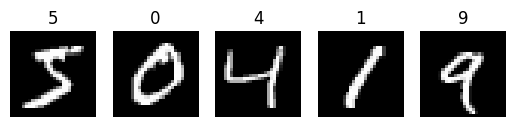

In [4]:
# It can also be helpful to have a proper look at specific samples of a dataset to understand what you are dealing with.
# Plot 5 samples with their corresponding labels.

fig, ax = plt.subplots(1,5)
for i in range(5):
    ### YOUR CODE HERE ###
    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]
    ######################
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

### Build the TensorFlow dataset.

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# It makes sense to shuffle the training dataset.
train_dataset = train_dataset.shuffle(buffer_size=60000)
# Further we have seen that it is advantageous to train with mini-batches instead of one sample at a time.
train_dataset = train_dataset.batch(128)
# Let's have a look at how the elements of the dataset now look.
for elem in train_dataset:
    print(elem[0].shape) # 128 images as one batch is our train dataset, images still have shape 28x28 
    print(elem[1].shape) # 128 labels for the 128 images
    break
# The test dataset can be processed in full batch.
test_dataset = test_dataset.batch(10000)

(128, 28, 28)
(128,)


### Build the model.

In [6]:
# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 784 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.
# 
# Instead of implementing our own layer we can directly implement the network using pre-built layers 
# from TensorFlow.
# For that check out 'tf.keras.layers.Dense(units= , activation=)'. It is basically the same layer that we
# implemented by hand last time. Except that you can include the activation function into the layer.
# For activations functions check out 'tf.keras.activations'.

from tensorflow.keras.layers import Layer

class Model(Layer):
    
    def __init__(self):
        super(Model, self).__init__()
        ### YOUR CODE HERE ###
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units = 256, activation = "sigmoid")
        self.hidden_layer_2 = tf.keras.layers.Dense(units = 256, activation = "sigmoid")
        self.output_layer = tf.keras.layers.Dense(units = 10, activation = "softmax")
        ######################
      
    def call(self, x):
        ### YOUR CODE HERE ###
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        ######################
        return x

### Question:

*Q: How many parameters does this network have?*  
A: (784 \* 256) + (256 \* 256) + (256 \* 10) = 268.800 parameters

### Train the model.

In [7]:
tf.keras.backend.clear_session()

### YOUR CODE HERE ###
# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cce = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'.
adam = tf.keras.optimizers.Adam()
######################

# Initialize lists for later visualization.
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
step = 0


# We train for 3 epochs.
for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    
    for (x,t) in train_dataset:
        
        ### YOUR CODE HERE ###
        # We need to reshape the input from [batchsize,28,28] to [batchsize,784].
        x = tf.reshape(x, shape=(-1, 784))
        # Further we need to transform the labels into a one-hot encoding.
        # Check out 'tf.one_hot'.
        t = tf.one_hot(t, 10)
        ######################
        
        ### YOUR CODE HERE ###
        # Compute the output, loss and the gradients
        with tf.GradientTape() as tape:
          x = x/255
          output = model(x)
          loss = cce(t, output)
          gradients = tape.gradient(loss, model.trainable_variables)
        # Apply gradients.
        adam.apply_gradients(zip(gradients, model.trainable_variables))
        ######################
        
        # Compute the accuracy.
        accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
        # Store loss and accuracy.
        train_accuracies.append(accuracy)
        train_losses.append(loss)
        
        # After each 25 training step we check the generalization to the test dataset.
        
        if step % 25 == 0:
            for (x,t) in test_dataset:
                ### YOUR CODE HERE ###
                # Compute loss and accuracy for the test data.
                x = tf.reshape(x, shape=(-1, 784))
                t = tf.one_hot(t, 10)
                x = x/255
                output = model(x)
                loss = cce(t, output)
                accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
                ######################
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(loss)

        # Monitoring the training process
        if step % 100 == 0:
            print(f"Step: {step}, Loss: {loss}, Accuracy: {accuracy}")
        
        train_steps.append(step)
        step += 1

Epoch 1/3
Step: 0, Loss: 2.3630409240722656, Accuracy: 0.098
Step: 100, Loss: 0.6095251441001892, Accuracy: 0.8593
Step: 200, Loss: 0.36393284797668457, Accuracy: 0.9033
Step: 300, Loss: 0.2995116710662842, Accuracy: 0.9136
Step: 400, Loss: 0.26773399114608765, Accuracy: 0.9204
Epoch 2/3
Step: 500, Loss: 0.2430664598941803, Accuracy: 0.9274
Step: 600, Loss: 0.23821566998958588, Accuracy: 0.928
Step: 700, Loss: 0.2161887139081955, Accuracy: 0.9347
Step: 800, Loss: 0.19981887936592102, Accuracy: 0.9423
Step: 900, Loss: 0.192102313041687, Accuracy: 0.9412
Epoch 3/3
Step: 1000, Loss: 0.1809813678264618, Accuracy: 0.9459
Step: 1100, Loss: 0.17352233827114105, Accuracy: 0.9491
Step: 1200, Loss: 0.1582370400428772, Accuracy: 0.9538
Step: 1300, Loss: 0.15287025272846222, Accuracy: 0.9536
Step: 1400, Loss: 0.1475011557340622, Accuracy: 0.9561


### Visualize the training progress.

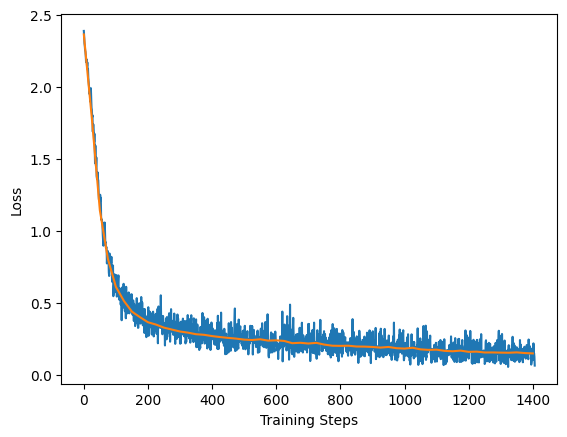

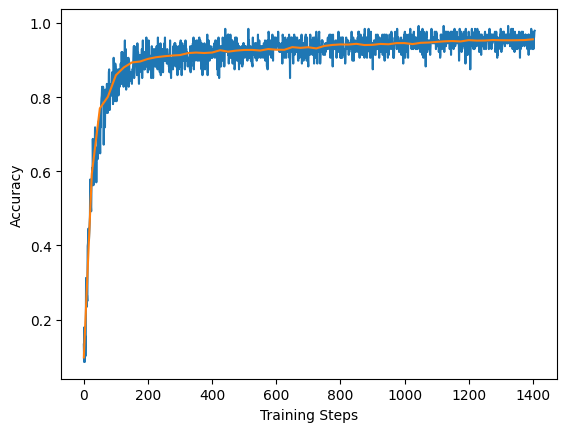

In [8]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
### YOUR CODE HERE ###
plt.figure()
plt.plot(train_steps, train_losses)
plt.plot(test_steps, test_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(train_steps, train_accuracies)
plt.plot(test_steps, test_accuracies)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.show()
#####################